In [570]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pydicom
import cv2
import numpy as np
import os
from pathlib import Path

In [572]:
def load_and_preprocess_dicom(dicom_dir, mask_dir, output_dir, patch_size=21, num_patches=100):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)
    
    slices = []
    masks = []
    
    dicom_files = sorted(list(Path(dicom_dir).glob("**/image_[0-9]*")))
    if not dicom_files:
        raise FileNotFoundError("No DICOM files found in PATIENT_DICOM. Expected files like image_0, image_1, etc.")
    
    for file in dicom_files:
        try:
            ds = pydicom.dcmread(file)
            image = ds.pixel_array.astype(np.float32)
            image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_CUBIC)  # Increased resolution
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)  # Normalize to [0, 1]
            slices.append(image)
            np.save(os.path.join(output_dir, "images", f"slice_{file.stem}.npy"), image)
        except Exception as e:
            continue
    
    mask_files = sorted(list(Path(mask_dir).glob("**/image_[0-9]*")))
    if not mask_files:
        raise FileNotFoundError("No mask files found in MASKS_DICOM. Expected files like image_0, image_1, etc.")
    
    for file in mask_files:
        try:
            ds = pydicom.dcmread(file)
            mask = ds.pixel_array.astype(np.uint8)
            mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)  # Increased resolution
            mask = (mask > 0).astype(np.uint8)
            # Check if mask has any positive pixels
            if mask.sum() == 0:
                print(f"Warning: Mask {file.stem} has no positive pixels after preprocessing.")
            masks.append(mask)
            np.save(os.path.join(output_dir, "masks", f"mask_{file.stem}.npy"), mask)
        except Exception as e:
            continue
    
    if len(masks) != len(slices):
        if len(masks) > len(slices):
            masks = masks[:len(slices)]
        else:
            slices = slices[:len(masks)]
    
    return np.array(slices), np.array(masks), np.array(patches)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [620]:
class LiverDataset(Dataset):
    def __init__(self, image_dir, mask_dir, indices=None, augment=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.augment = augment
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.startswith("slice_image_")])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.startswith("mask_image_")])
        
        if len(self.image_files) != len(self.mask_files):
            raise ValueError(f"Mismatch in file counts: {len(self.image_files)} image files, but {len(self.mask_files)} mask files.")

        if indices is not None:
            max_index = min(len(self.image_files), len(self.mask_files)) - 1
            invalid_indices = [i for i in indices if i > max_index]
            if invalid_indices:
                raise ValueError(f"Indices {invalid_indices} are out of range for the available files (max index: {max_index}).")
            self.image_files = [self.image_files[i] for i in indices]
            self.mask_files = [self.mask_files[i] for i in indices]

        # Define augmentations
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.RandomRotation(degrees=15),
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear=10),
            transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        number = self.image_files[idx].split('_')[-1].replace('.npy', '')
        mask_filename = f"mask_image_{number}.npy"
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = np.load(image_path)
        mask = np.load(mask_path)

        image = torch.FloatTensor(image).unsqueeze(0)
        mask = torch.FloatTensor(mask).unsqueeze(0)

        # Apply augmentations
        if self.augment:
            # Stack image and mask to apply the same transformation
            combined = torch.cat([image, mask], dim=0)
            combined = self.transform(combined)
            image, mask = combined[0:1], combined[1:2]

        return image, mask

In [143]:
from PIL import Image, ImageDraw
from io import BytesIO
from IPython.display import display, Image as IPyImage

In [145]:
def display_pil_image(pil_img):
    buffered = BytesIO()
    pil_img.save(buffered, format="PNG")
    img_bytes = buffered.getvalue()
    display(IPyImage(data=img_bytes))

In [147]:
def plot_sample(image, mask, title="Sample Input and Mask"):
    image = image.squeeze()
    mask = mask.squeeze()
    
    image = (image - image.min()) / (image.max() - image.min() + 1e-8) * 255
    image = image.astype(np.uint8)
    
    mask = (mask > 0).astype(np.uint8) * 255
    
    plot_width, plot_height = 128, 128  # Updated for new resolution
    canvas = Image.new("RGB", (plot_width * 2, plot_height), "white")
    draw = ImageDraw.Draw(canvas)

    for y in range(plot_height):
        for x in range(plot_width):
            src_x = int(x * image.shape[1] / plot_width)
            src_y = int(y * image.shape[0] / plot_height)
            pixel = int(image[src_y, src_x])
            canvas.putpixel((x, y), (pixel, pixel, pixel))

    for y in range(plot_height):
        for x in range(plot_width):
            src_x = int(x * mask.shape[1] / plot_width)
            src_y = int(y * mask.shape[0] / plot_height)
            value = mask[src_y, src_x]
            if value > 0:
                color = (255, 0, 0)
            else:
                color = (0, 0, 255)
            canvas.putpixel((x + plot_width, y), color)

    draw.text((plot_width // 4, 10), "CT Slice", fill="black")
    draw.text((plot_width + plot_width // 4, 10), "Ground Truth Mask", fill="black")
    draw.text((plot_width // 2, plot_height - 20), title, fill="black")

    display_pil_image(canvas)

In [478]:
def plot_prediction(image, mask, prediction, epoch):
    image = image.squeeze()
    mask = mask.squeeze()
    prediction = torch.sigmoid(prediction).detach().cpu().numpy().squeeze()
    prediction_raw = prediction.copy() * 255
    prediction = post_process(prediction)
        
    image = (image - image.min()) / (image.max() - image.min() + 1e-8) * 255
    image = image.astype(np.uint8)
    
    mask = (mask > 0).astype(np.uint8) * 255
    prediction = (prediction > 0).astype(np.uint8) * 255
    
    plot_width, plot_height = 128, 128  # Updated for new resolution
    canvas = Image.new("RGB", (plot_width * 4, plot_height), "white")
    draw = ImageDraw.Draw(canvas)

    for y in range(plot_height):
        for x in range(plot_width):
            src_x = int(x * image.shape[1] / plot_width)
            src_y = int(y * image.shape[0] / plot_height)
            pixel = int(image[src_y, src_x])
            canvas.putpixel((x, y), (pixel, pixel, pixel))

    for y in range(plot_height):
        for x in range(plot_width):
            src_x = int(x * mask.shape[1] / plot_width)
            src_y = int(y * mask.shape[0] / plot_height)
            value = mask[src_y, src_x]
            if value > 0:
                color = (255, 0, 0)
            else:
                color = (0, 0, 255)
            canvas.putpixel((x + plot_width, y), color)

    # Predicted Mask (Thresholded)
    for y in range(plot_height):
        for x in range(plot_width):
            src_x = int(x * prediction.shape[1] / plot_width)
            src_y = int(y * prediction.shape[0] / plot_height)
            value = prediction[src_y, src_x]
            if value > 0:
                color = (255, 0, 0)
            else:
                color = (0, 0, 255)
            canvas.putpixel((x + plot_width * 2, y), color)

    # Raw Probabilities (Heatmap)
    for y in range(plot_height):
        for x in range(plot_width):
            src_x = int(x * prediction_raw.shape[1] / plot_width)
            src_y = int(y * prediction_raw.shape[0] / plot_height)
            value = int(prediction_raw[src_y, src_x])
            canvas.putpixel((x + plot_width * 3, y), (value, 0, 255 - value))

    draw.text((plot_width // 4, 10), "CT Slice", fill="black")
    draw.text((plot_width + plot_width // 4, 10), "Ground Truth Mask", fill="black")
    draw.text((plot_width * 2 + plot_width // 4, 10), f"Predicted Mask (Epoch {epoch})", fill="black")
    draw.text((plot_width * 3 + plot_width // 4, 10), "Raw Probabilities", fill="black")

    display_pil_image(canvas)

In [692]:
def plot_loss(losses, title="Training Loss Over Epochs"):
    print(f"{title}")
    print("Epoch,Loss")
    for epoch, loss in enumerate(losses, 1):
        print(f"{epoch},{loss:.4f}")

    img_width, img_height = 200, 100
    image = Image.new("RGB", (img_width, img_height), "white")
    draw = ImageDraw.Draw(image)

    min_loss = min(losses)
    max_loss = max(losses)
    if max_loss == min_loss:
        scaled_losses = [img_height // 2] * len(losses)
    else:
        scaled_losses = [
            img_height - int(img_height * (loss - min_loss) / (max_loss - min_loss))
            for loss in losses
        ]

    for i in range(len(scaled_losses) - 1):
        x0 = int(i * (img_width - 1) / (len(losses) - 1))
        x1 = int((i + 1) * (img_width - 1) / (len(losses) - 1))
        y0 = scaled_losses[i]
        y1 = scaled_losses[i + 1]
        draw.line((x0, y0, x1, y1), fill="black", width=1)

    draw.text((img_width // 4, 10), title, fill="black")
    display_pil_image(image)

In [578]:
def compute_dice(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred).detach().cpu()  
    pred = (pred > 0.1).float()  
    target = target.detach().cpu().float()
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()

In [694]:
def plot_dice(dice_scores, title="Dice Coefficient Over Epochs"):
    print(f"{title}")
    print("Epoch,Dice")
    for epoch, dice in enumerate(dice_scores, 1):
        print(f"{epoch},{dice:.4f}")

    img_width, img_height = 200, 100
    image = Image.new("RGB", (img_width, img_height), "white")
    draw = ImageDraw.Draw(image)

    min_dice = min(dice_scores)
    max_dice = max(dice_scores)
    if max_dice == min_dice:
        scaled_dice = [img_height // 2] * len(dice_scores)
    else:
        scaled_dice = [
            img_height - int(img_height * (dice - min_dice) / (max_dice - min_dice))
            for dice in dice_scores
        ]

    for i in range(len(scaled_dice) - 1):
        x0 = int(i * (img_width - 1) / (len(dice_scores) - 1))
        x1 = int((i + 1) * (img_width - 1) / (len(dice_scores) - 1))
        y0 = scaled_dice[i]
        y1 = scaled_dice[i + 1]
        draw.line((x0, y0, x1, y1), fill="black", width=1)

    draw.text((img_width // 4, 10), title, fill="black")
    display_pil_image(image)

In [27]:
def plot_intensity_histogram(images, title="Pixel Intensity Histogram"):
    # Flatten all images and compute histogram
    images = images.reshape(-1)  # Flatten to 1D array
    hist, bins = np.histogram(images, bins=50, range=(0, 1))  # Images are normalized to [0, 1]
    
    # Normalize histogram heights for plotting
    max_height = 100  # Max height of the histogram in pixels
    hist = hist / hist.max() * max_height if hist.max() > 0 else hist  # Scale to max_height
    
    # Create a canvas for the histogram
    img_width, img_height = 200, 120
    image = Image.new("RGB", (img_width, img_height), "white")
    draw = ImageDraw.Draw(image)

    # Draw histogram bars
    bin_width = img_width / len(hist)
    for i, h in enumerate(hist):
        x0 = int(i * bin_width)
        x1 = int((i + 1) * bin_width)
        y0 = img_height - 10  # Leave space for title
        y1 = img_height - 10 - int(h)
        draw.rectangle([x0, y1, x1, y0], fill="blue")

    draw.text((img_width // 4, 10), title, fill="black")
    display_pil_image(image)

In [582]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5, weight_positive=30.0, reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.weight_positive = weight_positive
        self.reduction = reduction

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        target = target.float()

        # Compute intersection and sums with weighting for positive class
        intersection = (pred * target).sum(dim=(2, 3))  # Sum over height and width
        pred_sum = pred.sum(dim=(2, 3))
        target_sum = target.sum(dim=(2, 3))

        # Apply weighting to positive class
        weighted_intersection = (pred * target * self.weight_positive).sum(dim=(2, 3))
        weighted_pred_sum = (pred * self.weight_positive).sum(dim=(2, 3))
        weighted_target_sum = (target * self.weight_positive).sum(dim=(2, 3))

        # Use weighted terms for positive class, unweighted for negative
        intersection = weighted_intersection + (pred * (1 - target)).sum(dim=(2, 3))
        pred_sum = weighted_pred_sum + (pred * (1 - target)).sum(dim=(2, 3))
        target_sum = weighted_target_sum + ((1 - target) * target).sum(dim=(2, 3))

        # Compute Dice coefficient
        dice = (2. * intersection + self.smooth) / (pred_sum + target_sum + self.smooth)

        loss = 1 - dice

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [474]:
import scipy.ndimage as ndimage

def post_process(prediction):
    prediction = (prediction > 0.2).astype(np.uint8)
    labeled, num_features = ndimage.label(prediction)
    if num_features > 0:
        sizes = ndimage.sum(prediction, labeled, range(num_features + 1))
        mask_size = sizes < 50  
        remove_pixel = mask_size[labeled]
        prediction[remove_pixel] = 0
    return prediction

In [648]:
def print_conclusion(train_losses, val_dice_scores, total_epochs):
    print("\n" + "="*50)
    print("Conclusion and Final Results")
    print("="*50 + "\n")

    # Model Performance
    final_dice = val_dice_scores[-1]
    print("Model Performance:")
    if final_dice > 0.7:
        interpretation = "good overlap between predicted and ground truth masks"
    elif final_dice > 0.4:
        interpretation = "moderate performance requiring further improvement"
    else:
        interpretation = "poor performance, indicating significant issues in segmentation"
    print(f"- Achieved a final validation Dice coefficient of {final_dice:.4f} after {total_epochs} epochs, indicating {interpretation}.")
    
    initial_loss = train_losses[0]
    final_loss = train_losses[-1]
    initial_dice = val_dice_scores[0]
    dice_improvement = ((final_dice - initial_dice)/initial_dice)*100
    print("Training Insights:")
    print(f"- Training loss decreased from {initial_loss:.4f} to {final_loss:.4f} over {total_epochs} epochs.")
    print(f"- Validation Dice coefficient improved by {dice_improvement:.4f} % (from {initial_dice:.4f} to {final_dice:.4f}), reflecting the model's ability to better delineate lesions over time.\n")

In [734]:
image_dir = "/Users/Varun/Downloads/3Dircadb1/preprocessed_data/images"
mask_dir = "/Users/Varun/Downloads/3Dircadb1/preprocessed_data/masks"

In [736]:
num_samples = len([f for f in os.listdir(image_dir) if f.startswith("slice_image_")])
indices = list(range(num_samples))  # Use all samples
np.random.shuffle(indices)
train_size = int(0.8 * len(indices))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

In [738]:
train_dataset = LiverDataset(image_dir, mask_dir, train_indices)
val_dataset = LiverDataset(image_dir, mask_dir, val_indices)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

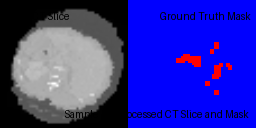

In [740]:
# Visualize a sample
sample_image, sample_mask = train_dataset[0]
plot_sample(sample_image.numpy(), sample_mask.numpy(), "Sample Preprocessed CT Slice and Mask")

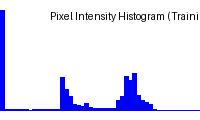

In [742]:
# Plot intensity histogram for a few training samples
sample_images = [train_dataset[i][0].numpy().squeeze() for i in range(min(5, len(train_dataset)))]
sample_images = np.array(sample_images)
plot_intensity_histogram(sample_images, "Pixel Intensity Histogram (Training Samples)")

In [744]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, smooth=1e-5):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        target = target.float()
        tp = (pred * target).sum(dim=(2, 3))
        fn = (target * (1 - pred)).sum(dim=(2, 3))
        fp = ((1 - target) * pred).sum(dim=(2, 3))
        tversky = (tp + self.smooth) / (tp + self.alpha * fn + self.beta * fp + self.smooth)
        loss = 1 - tversky
        return loss.mean()

In [746]:
# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import segmentation_models_pytorch as smp

# Use a pretrained U-Net with a ResNet18 backbone
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
).to(device)
pos_weight = torch.tensor([30.0]).to(device) 
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
dice_loss = DiceLoss(smooth=1e-5, weight_positive=30.0, reduction='mean')
tversky_loss = TverskyLoss(alpha=0.8, beta=0.2, smooth=1e-5)
criterion = lambda pred, target: 0.6 * bce_loss(pred, target) + 0.2 * dice_loss(pred, target) + 0.2 * tversky_loss(pred, target)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)

In [748]:
import gc

In [750]:
weights = []
for idx in train_indices:
    mask_path = os.path.join(mask_dir, f"mask_image_{idx}.npy")
    mask = np.load(mask_path)
    weight = mask.sum()
    weights.append(weight if weight > 0 else 1e-5)
weights = np.array(weights)
weights = weights / weights.sum()
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler)

Epoch [1/5], Loss: 0.3195
Epoch [2/5], Loss: 0.3067
Epoch [3/5], Loss: 0.3261
Epoch [4/5], Loss: 0.3164
Epoch [5/5], Loss: 0.3084


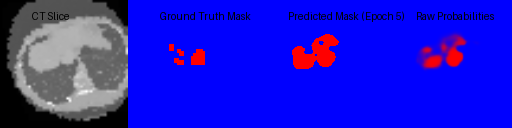

In [806]:
# Training Loop
num_epochs = 5
train_losses = []
val_dice_scores = []
best_dice = 0
patience = 10
counter = 0

latest_val_image = None
latest_val_mask = None
latest_pred = None
latest_epoch = 0

warmup_epochs = 5
initial_lr = 0.0001
final_lr = 0.0005

try:
    for epoch in range(num_epochs):
        if epoch < warmup_epochs:
            lr = initial_lr + (final_lr - initial_lr) * (epoch / warmup_epochs)
            
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        # Compute Dice coefficient on validation set
        model.eval()
        dice_scores = []
        with torch.no_grad():
            for val_images, val_masks in val_loader:
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)
                val_pred = model(val_images)
                dice = compute_dice(val_pred, val_masks)
                dice_scores.append(dice)
                if latest_val_image is None or epoch == 0:
                    latest_val_image = val_images.cpu().numpy()
                    latest_val_mask = val_masks.cpu().numpy()
                    latest_pred = val_pred.cpu()
                    latest_epoch = epoch + 1
        avg_dice = sum(dice_scores) / len(dice_scores)
        val_dice_scores.append(avg_dice)
        scheduler.step(avg_dice)
    
        if avg_dice > best_dice:
            best_dice = avg_dice
            counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            with torch.no_grad():
                val_image, val_mask = next(iter(val_loader))
                val_image, val_mask = val_image.to(device), val_mask.to(device)
                pred = model(val_image)
                latest_val_image = val_image.cpu().numpy()
                latest_val_mask = val_mask.cpu().numpy()
                latest_pred = pred.cpu()
                latest_epoch = epoch + 1
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) == num_epochs:
            with torch.no_grad():
                val_image, val_mask = next(iter(val_loader))
                val_image, val_mask = val_image.to(device), val_mask.to(device)
                pred = model(val_image)
                latest_val_image = val_image.cpu().numpy()
                latest_val_mask = val_mask.cpu().numpy()
                latest_pred = pred.cpu()
                latest_epoch = epoch + 1
        
        gc.collect()

finally:
    if latest_val_image is not None and latest_val_mask is not None and latest_pred is not None:
        model.load_state_dict(torch.load("best_model.pth"))
        model.eval()
        with torch.no_grad():
            val_image = torch.tensor(latest_val_image).to(device)
            pred = model(val_image)
        plot_prediction(latest_val_image, latest_val_mask, pred.cpu(), latest_epoch)
    else:
        print("No validation data available to plot.")

Training Loss
Epoch,Loss
1,0.3195
2,0.3067
3,0.3261
4,0.3164
5,0.3084


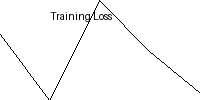

In [808]:
# Plot the overall loss and Dice scores
plot_loss(train_losses, "Training Loss")

Dice Coefficient
Epoch,Dice
1,0.3891
2,0.3794
3,0.4005
4,0.4164
5,0.4244


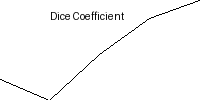

In [810]:
plot_dice(val_dice_scores, "Dice Coefficient")

In [816]:
print_conclusion(train_losses, val_dice_scores, total_epochs)


Conclusion and Final Results

Model Performance:
- Achieved a final validation Dice coefficient of 0.4244 after 5 epochs, indicating moderate performance requiring further improvement.
Training Insights:
- Training loss decreased from 0.3195 to 0.3084 over 5 epochs.
- Validation Dice coefficient improved by 9.0843 % (from 0.3891 to 0.4244), reflecting the model's ability to better delineate lesions over time.

